In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse

from tqdm import tqdm

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [38]:
radar_model_1 = mmars.FmcwRadar( 
                 position = np.array([[0,0]]),
                 tx_antennas = None,
                 rx_antennas = None, 
                 chirp_Rate = 20*1e12, 
                 T_between_chirps = 128/(10e6), 
                 f_carrier = 77e9, 
                 N_samples = 128, 
                 f_sampling = 3e6,
                 N_chirps = 1,
                 transmitPower = 1,
                 gain = 1,
                 radarCrossSection = 1,
                 signalNoiseRatio = [0, 10]
                                    )
#radar_model_2 = mmars.FmcwRadar(position=np.array([[0,10]]), signalNoiseRatio=[10, 10], N_chirps=1)
#radar_model_3 = mmars.FmcwRadar(position=np.array([[0,20]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [39]:
T_frame = 0.1

target_model_1 = mmars.Target(start_position=np.array([[0.,5.]]), start_velocity=1., T_total=17., T_frame=T_frame)

target_model_1.generate_trajectory(trajectory_type="linear")

target_ground_truth = target_model_1.get_trajectory()

print(radar_model_1.get_parameters)

mrblatcomp = mmars.MRBLaT_Functions(radar_model_1.get_parameters)

{'position': array([[0, 0]]), 'tx_antennas': array([[-0.02336045,  0.        ],
       [-0.01557363,  0.        ],
       [-0.00778682,  0.        ]]), 'rx_antennas': array([[-0.00292006,  0.        ],
       [-0.00097335,  0.        ],
       [ 0.00097335,  0.        ],
       [ 0.00292006,  0.        ]]), 'chirp_Rate': 20000000000000.0, 'T_between_chirps': 1.28e-05, 'f_carrier': 77000000000.0, 'N_samples': 128, 'f_sampling': 3000000.0, 'N_chirps': 1, 'transmitPower': 1, 'gain': 1, 'radarCrossSection': 1, 'signalNoiseRatio': [0, 10], 'standardDeviation': np.float64(8.740075449196408e-07), 'wavelength': 0.0038934085454545454, 'max_range': 22.48443435}


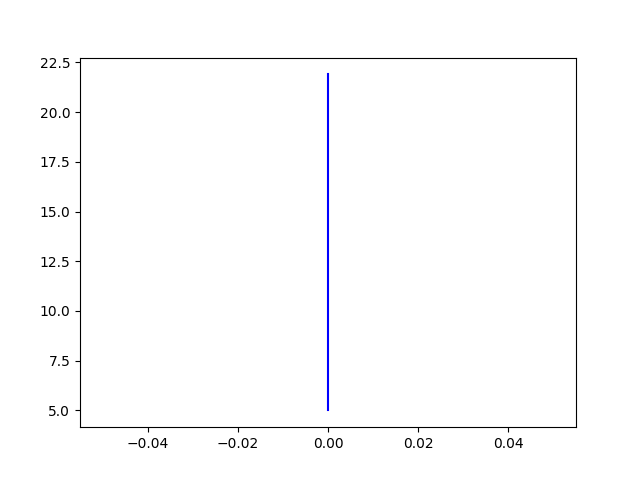

In [40]:
plt.figure()
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [41]:
simulation_data_1 = mmars.Simulation(radar_model_1, target_model_1)
#simulation_data_2 = mmars.Simulation(radar_model_2, target_model_1)
#simulation_data_3 = mmars.Simulation(radar_model_3, target_model_1)

simulation_data_1.run()
#simulation_data_2.run()
#simulation_data_3.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000002DC24001100> and <mmars.target.Target object at 0x000002DC1D1F8B60>


100%|██████████| 170/170 [00:00<00:00, 1104.26it/s]


In [42]:
sim_data_1 = simulation_data_1.get_data()
#sim_data_2 = simulation_data_2.get_data()
#sim_data_3 = simulation_data_3.get_data()

In [43]:
radar_model_1.get_standardDeviation**2

np.float64(7.638891885764579e-13)

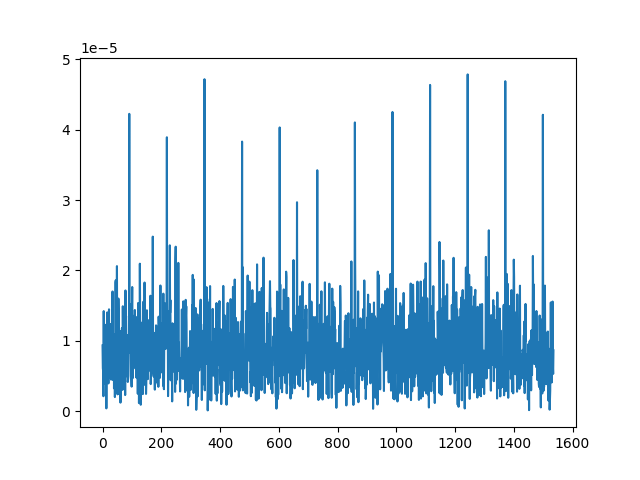

In [48]:
plt.figure()
data_fourier = np.fft.fft(sim_data_1[110], axis=-1).flatten()
plt.plot(np.abs(data_fourier))

In [55]:
frame = 0

x0 = [target_ground_truth[0][frame], target_ground_truth[1][frame],0.1,0.1]
bound = ((-2, 2), (0, 20), (0.000001, 10), (0.000001, 10))


sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()

D_KL_result = minimize(mrblatcomp.D_KL, x0, bounds = bound, args=(data_fourier, x0, (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
D_KL_result.x

array([7.42073040e-04, 5.00154526e+00, 1.00000000e-06, 1.00000000e-06])

In [25]:
jacobian = mrblatcomp.jacobian_S_A([0, 10])

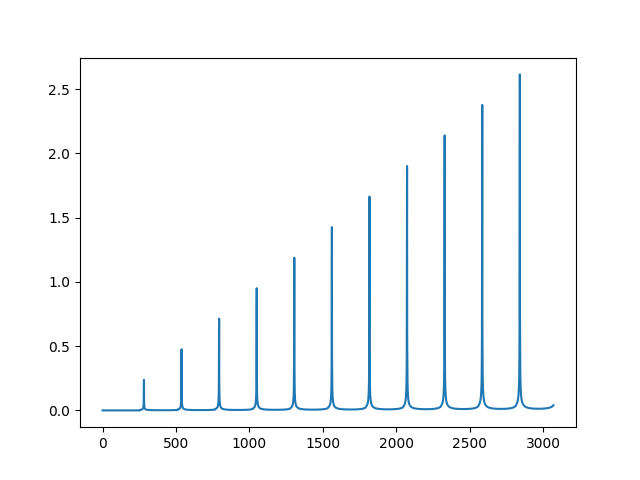

In [26]:
plt.figure()
plt.plot(np.abs(jacobian[:,0]))

In [49]:
x0 = [target_ground_truth[0][0], target_ground_truth[1][0],0.1,0.1]
bound = ((-20, 20), (4, 60), (1e-10, 10), (1e-10, 10))

D_KL_results = np.zeros((len(sim_data_1), 4))

for n in tqdm(range(len(sim_data_1))):
    #print("Frame: ", n)
    data_fourier = np.fft.fft(sim_data_1[n], axis=-1).flatten()
    if n == 0:
        #print("First frame")
        D_KL_result = minimize(mrblatcomp.D_KL, x0, bounds = bound, args=(data_fourier, x0, (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
        
    else:
        #print("Not first frame")
        D_KL_result = minimize(mrblatcomp.D_KL, D_KL_results[n-1], bounds = bound, args=(data_fourier, D_KL_results[n-1], (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})

    D_KL_results[n] = D_KL_result.x
    #print(D_KL_result.x)
        

100%|██████████| 170/170 [00:49<00:00,  3.43it/s]


# MRBLaT

In [9]:
first_try = mmars.Tracking([sim_data_1], [radar_model_1.get_parameters], np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]]))

In [10]:
BLaT_phi_bar_sim, BLaT_phi_bar_bar_sim, alpha_hat, alpha_times_S, DKL_phi_bar, DKL_phi_bar_bar = first_try.run_mrblat(T_frame, N_frames=50, fifo_length=None,  bound = ((-10, 10), (4, 20), (1e-8, 10), (1e-8, 10)))

 34%|███▍      | 17/50 [00:14<00:09,  3.65it/s]c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS\mmars\tracking.py:87: OptimizeWarning: Initial guess is not within the specified bounds
  D_KL_result = minimize(mrblat_functions_list[k].D_KL, x0, bounds = bound,  args=(data_fourier, x0, (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


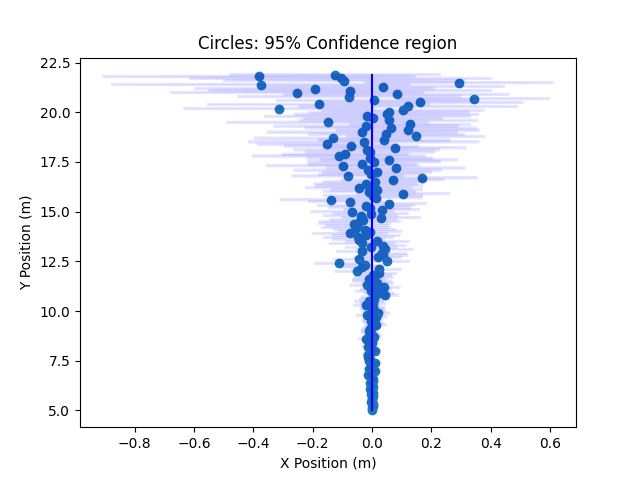

In [50]:
plt.figure()
plt.scatter(D_KL_results[:,0], D_KL_results[:, 1])#, label="MRBLAT", c=np.linspace(0, 1, len(D_KL_results[:, 0])), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0][:500], target_ground_truth[1][:500], label="Ground Truth", color="blue")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title('Circles: 95% Confidence region')
#plt.ylim(-1, 30)

for N_frame in range(len(D_KL_results)):
    mean_MR = np.array([D_KL_results[N_frame,0], D_KL_results[N_frame,1]])
    cov_MR = np.array([[D_KL_results[N_frame,2]**2, 0], [0, D_KL_results[N_frame,3]**2]])
    x_MR, y_MR = np.random.multivariate_normal(mean_MR, cov_MR, 10000).T
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues_MR, eigenvectors_MR = np.linalg.eigh(cov_MR)
    order_MR = eigenvalues_MR.argsort()[::-1]
    eigenvalues_MR, eigenvectors_MR = eigenvalues_MR[order_MR], eigenvectors_MR[:, order_MR]
    angle_MR = np.degrees(np.arctan2(*eigenvectors_MR[:, 0][::-1]))
    width_MR, height_MR = 2 * np.sqrt(eigenvalues_MR * 5.991)  # 5.991 is the chi-square value for 95% confidence
    # Create and add the ellipse to the plot
    ellipse_MR = Ellipse(xy=mean_MR, width=width_MR, height=height_MR, angle=angle_MR, edgecolor='blue', fc='blue', lw=2, alpha=0.1)
    plt.gca().add_patch(ellipse_MR)

Text(0, 0.5, 'Standard Deviation (m)')

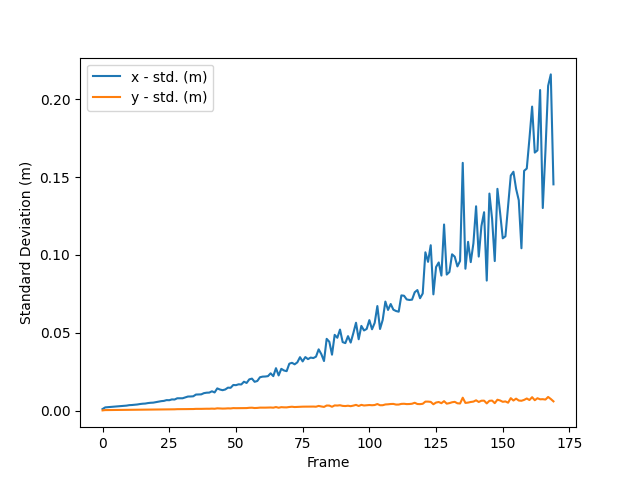

In [51]:
plt.figure()
plt.plot(D_KL_results[:,2], label="x - std. (m)")
plt.plot(D_KL_results[:,3], label="y - std. (m)")
plt.xlabel("Frame")
plt.legend()
plt.ylabel("Standard Deviation (m)")

In [19]:
gridsize = 300

# Define the range for phi[0] and phi[1]
x_values = np.linspace(-5, 5, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(15, 25, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [2],  [2]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (90000, 4, 1)


In [20]:
frame = 149
sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, [target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], 2, 2], outputmode=[1,1,1,1], print_output=False))

  0%|          | 0/90000 [00:00<?, ?it/s]

100%|██████████| 90000/90000 [00:42<00:00, 2100.06it/s]


Minimum value at index: (np.int64(145), np.int64(160))
x: 0.3511705685618729, y: 19.849498327759196


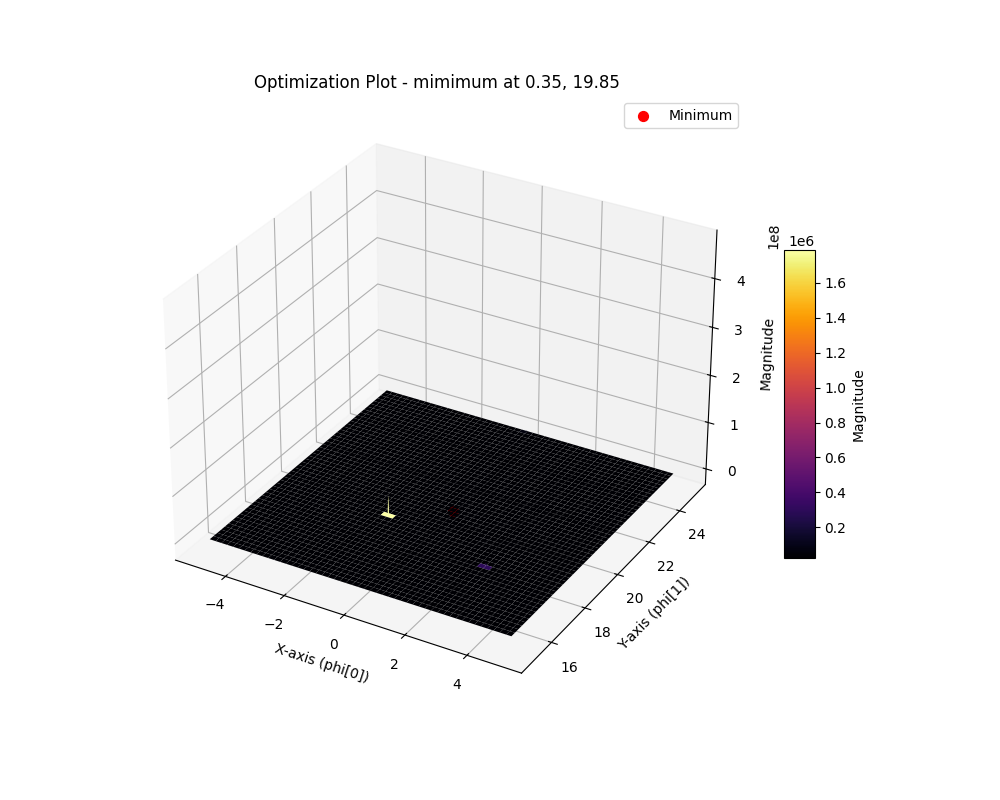

In [21]:
# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
heatmap = np.real(heatmap)
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(np.abs(heatmap))

# Plot the heatmap
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for x_values and y_values
X, Y = np.meshgrid(x_values, y_values)

# Plot the surface
surf = ax.plot_surface(X, Y, heatmap, cmap='inferno', edgecolor='none')

# Add a scatter point for the minimum value
ax.scatter(x_min, y_min, np.min(heatmap), color='red', label='Minimum', s=50)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Magnitude")

# Set labels and title
ax.set_xlabel("X-axis (phi[0])")
ax.set_ylabel("Y-axis (phi[1])")
ax.set_zlabel("Magnitude")
ax.set_title(f"Optimization Plot - mimimum at {x_min:.2f}, {y_min:.2f}")

plt.legend()
plt.show()

In [24]:
gridsize = 250

# Define the range for phi[0] and phi[1]
x_values = 10**(np.linspace(-100, 20, gridsize)/20) 
y_values = 10**(np.linspace(-100, 20, gridsize)/20)

#x_values = np.linspace(1e-15, 2, gridsize)
#y_values = np.linspace(1e-15, 2, gridsize)
# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x_min], [y_min], [x],  [y]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (62500, 4, 1)


In [25]:
frame = 149
sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, [x_min, y_min, 2, 2], print_output=False))

100%|██████████| 62500/62500 [00:29<00:00, 2092.02it/s]


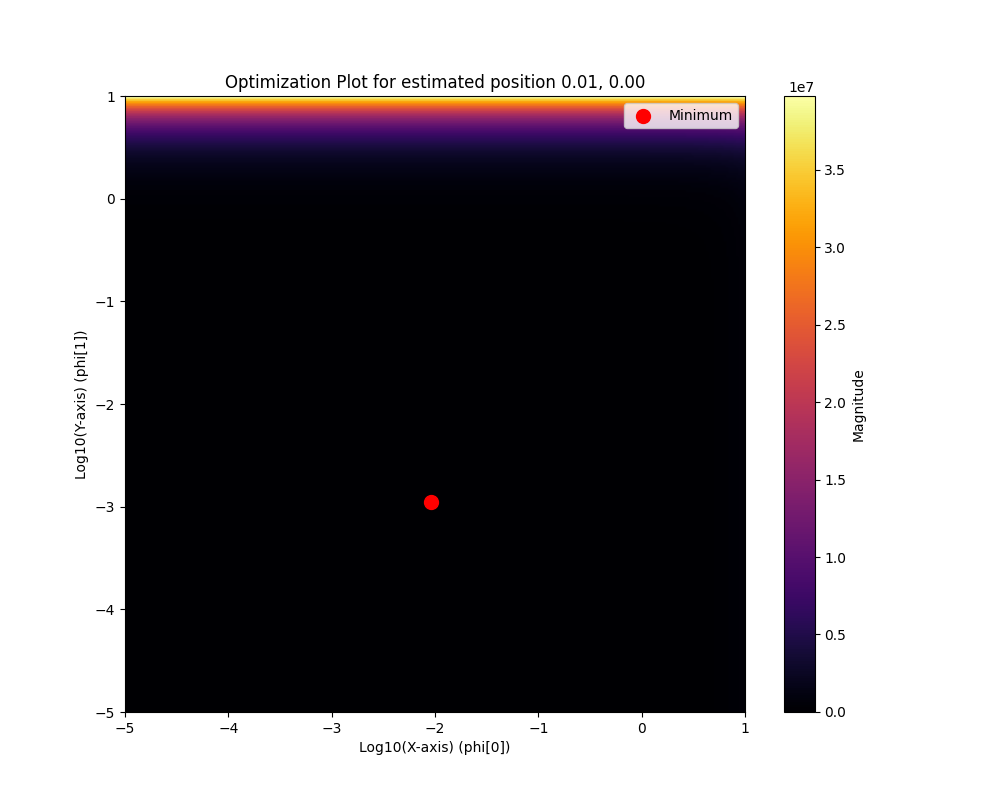

In [26]:
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(10, 8))

# Create a meshgrid for x_values and y_values
X, Y = np.meshgrid(x_values, y_values)

# Plot the heatmap
plt.imshow(heatmap.real, origin='lower', extent=[np.log10(x_values[0]), np.log10(x_values[-1]), np.log10(y_values[0]), np.log10(y_values[-1])], cmap='inferno', aspect='auto')

# Add color bar
plt.colorbar(label="Magnitude")

min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

# Add a scatter point for the minimum value
plt.scatter(np.log10(x_min), np.log10(y_min), color='red', label='Minimum', s=100)



# Set labels and title
plt.xlabel("Log10(X-axis) (phi[0])")
plt.ylabel("Log10(Y-axis) (phi[1])")
plt.title(f"Optimization Plot for estimated position {x_min:.2f}, {y_min:.2f}")

plt.legend()
plt.show()
